In [1]:
import pandas as pd
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
%matplotlib inline

# Import Data

In [2]:
df = pd.read_csv('wdbc.csv', names=['ID','Diagnosis','MeanRadius','MeanTexture','MeanPerimeter','MeanArea',
                                    'MeanSmoothness','MeanCompactness','MeanConcavity','MeanConcavePoints',
                                    'MeanSymmetry','MeanFractalDimension','RadiusSE','TextureSE','PerimeterSE',
                                    'AreaSE','SmoothnessSE','CompactnessSE','ConcavitySE','ConcavePointsSE',
                                    'SymmetrySE','FractalDimensionSE','WorstRadius','WorstTexture','WorstPerimeter',
                                    'WorstArea','WorstSmoothness','WorstCompactness','WorstConcavity',
                                    'WorstConcave Points','WorstSymmetry','WorstFractalDimension'])

# EDA

In [3]:
type(df)
df.info() #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                       569 non-null int64
Diagnosis                569 non-null object
MeanRadius               569 non-null float64
MeanTexture              569 non-null float64
MeanPerimeter            569 non-null float64
MeanArea                 569 non-null float64
MeanSmoothness           569 non-null float64
MeanCompactness          569 non-null float64
MeanConcavity            569 non-null float64
MeanConcavePoints        569 non-null float64
MeanSymmetry             569 non-null float64
MeanFractalDimension     569 non-null float64
RadiusSE                 569 non-null float64
TextureSE                569 non-null float64
PerimeterSE              569 non-null float64
AreaSE                   569 non-null float64
SmoothnessSE             569 non-null float64
CompactnessSE            569 non-null float64
ConcavitySE              569 non-null float64
ConcavePointsSE         

In [4]:
df.head(10)

,ID,Diagnosis,MeanRadius,MeanTexture,MeanPerimeter,MeanArea,MeanSmoothness,MeanCompactness,MeanConcavity,MeanConcavePoints,...,WorstRadius,WorstTexture,WorstPerimeter,WorstArea,WorstSmoothness,WorstCompactness,WorstConcavity,WorstConcave Points,WorstSymmetry,WorstFractalDimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [5]:
df.tail()

,ID,Diagnosis,MeanRadius,MeanTexture,MeanPerimeter,MeanArea,MeanSmoothness,MeanCompactness,MeanConcavity,MeanConcavePoints,...,WorstRadius,WorstTexture,WorstPerimeter,WorstArea,WorstSmoothness,WorstCompactness,WorstConcavity,WorstConcave Points,WorstSymmetry,WorstFractalDimension
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [6]:
df.describe()

,ID,MeanRadius,MeanTexture,MeanPerimeter,MeanArea,MeanSmoothness,MeanCompactness,MeanConcavity,MeanConcavePoints,MeanSymmetry,...,WorstRadius,WorstTexture,WorstPerimeter,WorstArea,WorstSmoothness,WorstCompactness,WorstConcavity,WorstConcave Points,WorstSymmetry,WorstFractalDimension
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


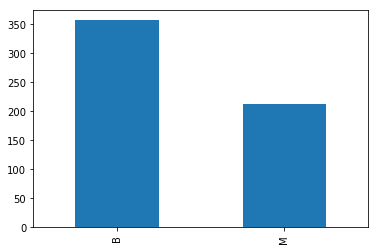

In [7]:
df['Diagnosis'].value_counts().plot(kind='bar');

## What are the mean, median and standard deviation of the “perimeter” feature?

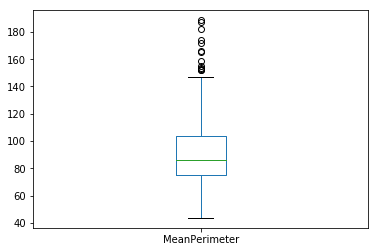

In [8]:
# Mean of the MeanPerimeter column is 91.97, from df.describe() table above.
# Median of MeanPerimeter is 86.24, and standard deviation of MeanPerimeter is 24.30.
df.MeanPerimeter.plot(kind='box');

## Is the first feature in this data set (the “radius”) normally distributed? Please quantitatively define you answer. If not, what might be a more appropriate distribution?

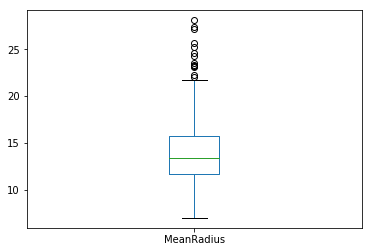

In [9]:
df.MeanRadius.plot(kind='box');

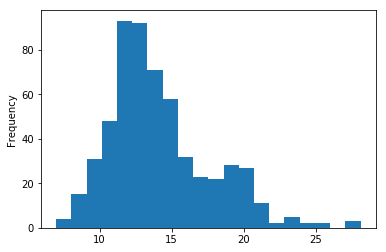

In [10]:
df.MeanRadius.plot(kind='hist', bins=20);
# Based on a histogram of the mean radius values, this feature does not look normally distributed.
# This distribution is right skewed.

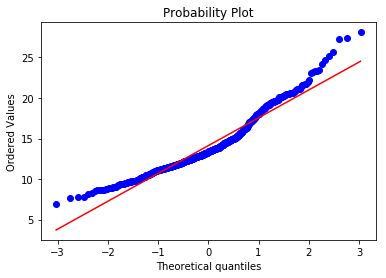

In [12]:
stats.probplot(df.MeanRadius, dist="norm", plot=pylab)
pylab.show()
# The QQ plot suggests the radius feature is not normal, as the blue data starts above the normal line, goes below, and 
# then goes back above, indicating some underlying patterns that are not well represented by a normal distribution.

In [13]:
# Shapiro-Wilk Test - a hypothesis test for if the distibution is normal
print('Null hypothesis: the radius is normally distributed.')
seed(1234)
stat, p = shapiro(df.MeanRadius)
print('Test Statistic = %.3f, p-value = %.6f.' % (stat, p))
# The p-value is neglibile for this test of the null hypothesis, and therefore at any level of signifcance we can reject the
# null hypothesis, and conclude that the radius is not normally distributed.

Null hypothesis: the radius is normally distributed.
Test Statistic = 0.941, p-value = 0.000000.


### A more appropriate distribution might be a Gamma distribution, or possibly an F distribution.

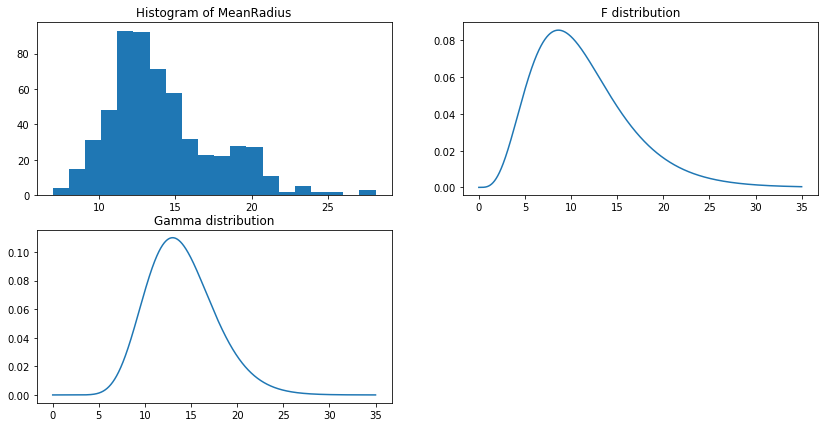

In [14]:
x = np.linspace(0.001, 35, 5000)
f, ax_arr = plt.subplots(2, 2, figsize=(14,7))

# Histogram
ax_arr[0,0].hist(df.MeanRadius, bins=20)
ax_arr[0,0].set_title('Histogram of MeanRadius')

# F distribution
yF=stats.f.pdf(x, 10, 100, 0, 11)
ax_arr[0,1].plot(x, yF);
ax_arr[0,1].set_title('F distribution')
# I played around with the parameters of the F distribution pdf, and found this combination gives a distribution which looks
# similar to our histogram of the MeanRadius.

# Gamma distribution
yGamma=stats.gamma.pdf(x, 14)
ax_arr[1,0].plot(x, yGamma);
ax_arr[1,0].set_title('Gamma distribution')
# The mean of MeanRadius is 14.13. When I use 14 as the shape parameter here, this gamma distribution looks similar to our 
# histogram of MeanRadius.

ax_arr[1,1].axis('off')
plt.show()

In [ ]:
# One could check if these Gamma/F distributions are appropriate using a Kolmogorov–Smirnov test.

## Train a classifier to predict the diagnosis of malignant or benign. Please compare the results of two classifiers e.g. SVM, logistic regression, decision tree etc.

In [32]:
# Deal with missing values (none), outliers and feature engineering.
# Look at ranges of all Mean features - do I need to standardize?
dfMeans = df[['Diagnosis','MeanRadius','MeanTexture','MeanPerimeter','MeanArea',
                                    'MeanSmoothness','MeanCompactness','MeanConcavity','MeanConcavePoints',
                                    'MeanSymmetry','MeanFractalDimension']]

In [33]:
dfMeans.describe()
# Many values always <1 but others larger, in particular MeanArea has a mean of 654.89 with largest value 2501.

,MeanRadius,MeanTexture,MeanPerimeter,MeanArea,MeanSmoothness,MeanCompactness,MeanConcavity,MeanConcavePoints,MeanSymmetry,MeanFractalDimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


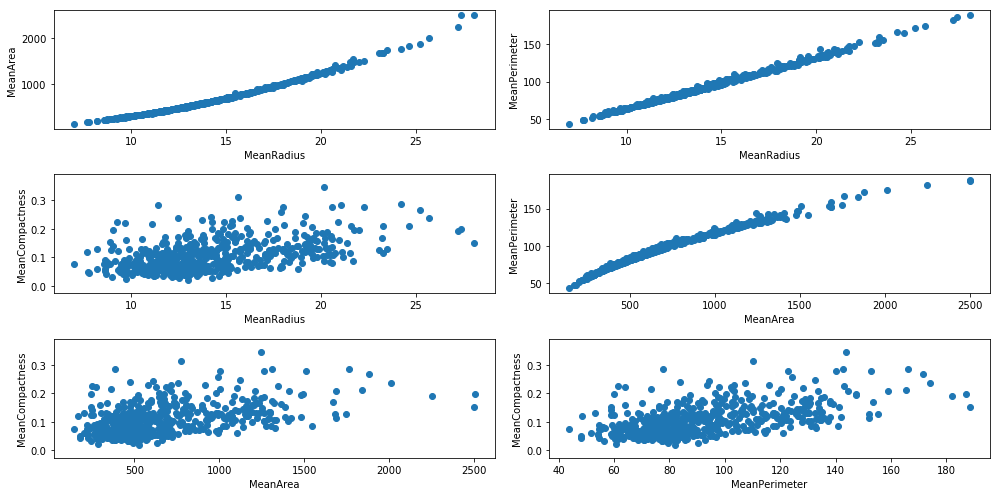

In [34]:
# Expect correlation/collinearity between Radius, Area, Perimeter and Compactness (perimeter^2 / area - 1.0)/
# As area takes such large values, could log or sqrt transform, but as area = pi * radius**2, could just use radius instead.
f, ax_arr = plt.subplots(3, 2, figsize=(14,7))

ax_arr[0,0].scatter(dfMeans.MeanRadius, dfMeans.MeanArea);
ax_arr[0,0].set_xlabel('MeanRadius')
ax_arr[0,0].set_ylabel('MeanArea')

ax_arr[0,1].scatter(dfMeans.MeanRadius, dfMeans.MeanPerimeter); 
ax_arr[0,1].set_xlabel('MeanRadius')
ax_arr[0,1].set_ylabel('MeanPerimeter')

ax_arr[1,0].scatter(dfMeans.MeanRadius, dfMeans.MeanCompactness);
ax_arr[1,0].set_xlabel('MeanRadius')
ax_arr[1,0].set_ylabel('MeanCompactness')

ax_arr[1,1].scatter(dfMeans.MeanArea, dfMeans.MeanPerimeter);
ax_arr[1,1].set_xlabel('MeanArea')
ax_arr[1,1].set_ylabel('MeanPerimeter')

ax_arr[2,0].scatter(dfMeans.MeanArea, dfMeans.MeanCompactness);
ax_arr[2,0].set_xlabel('MeanArea')
ax_arr[2,0].set_ylabel('MeanCompactness')

ax_arr[2,1].scatter(dfMeans.MeanPerimeter, dfMeans.MeanCompactness);
ax_arr[2,1].set_xlabel('MeanPerimeter')
ax_arr[2,1].set_ylabel('MeanCompactness')

plt.tight_layout()
plt.show()

# Suggests collinearity between radius and area, radius and perimeter, and perimeter and area.
# In context, I think radius is best feature to use out of all of these. Then will use compactness as well.

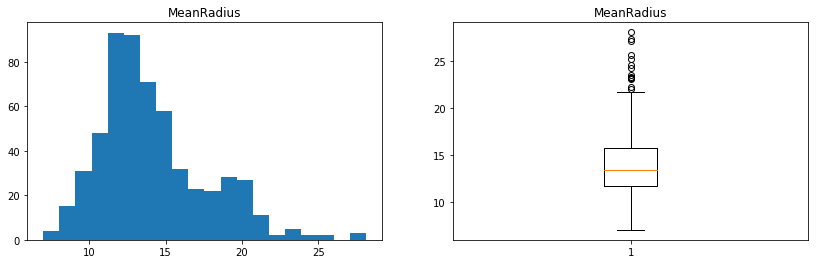

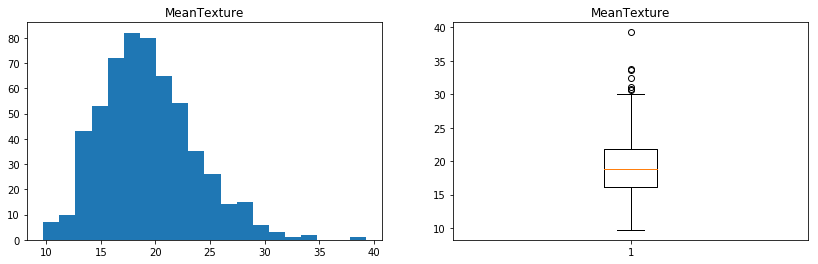

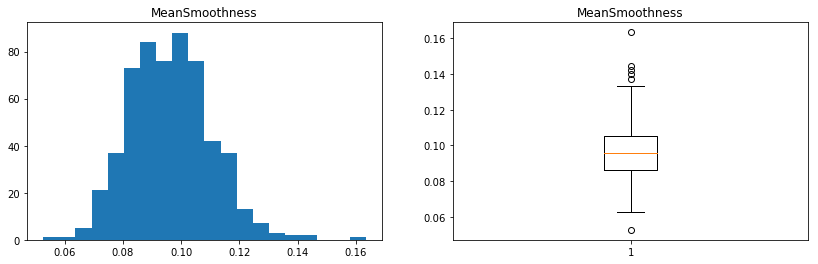

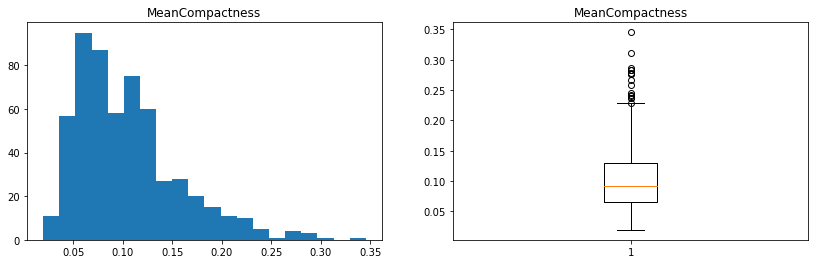

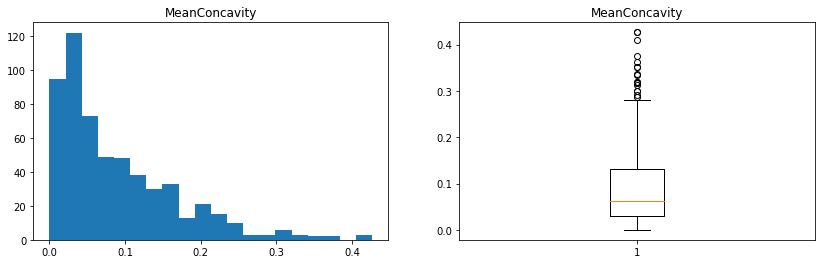

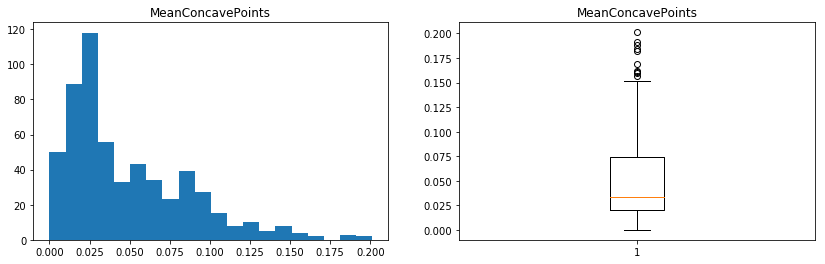

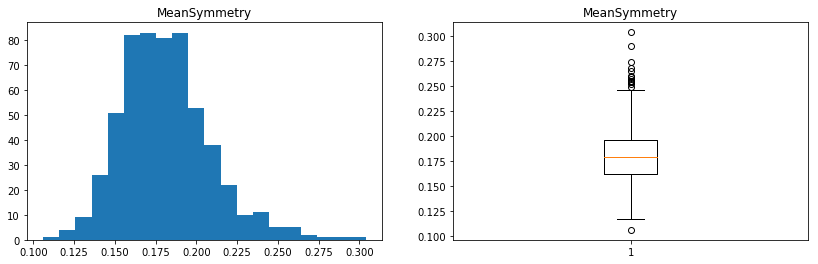

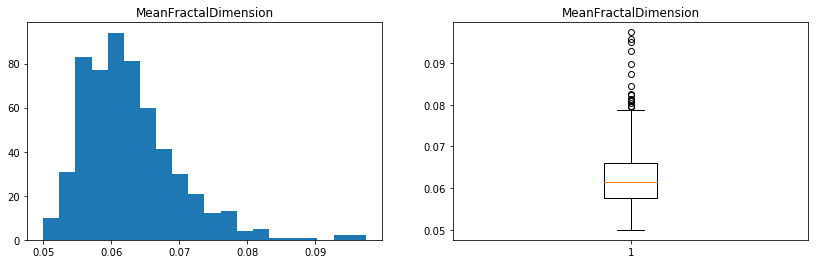

In [35]:
def outlierPlots(column, columnName):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    ax1.hist(column, bins=20);
    ax1.set_title(columnName)
    ax2.boxplot(column);
    ax2.set_title(columnName)
    plt.show()

outlierPlots(dfMeans.MeanRadius, 'MeanRadius')
outlierPlots(dfMeans.MeanTexture, 'MeanTexture')
outlierPlots(dfMeans.MeanSmoothness, 'MeanSmoothness')
outlierPlots(dfMeans.MeanCompactness, 'MeanCompactness')
outlierPlots(dfMeans.MeanConcavity, 'MeanConcavity')
outlierPlots(dfMeans.MeanConcavePoints, 'MeanConcavePoints')
outlierPlots(dfMeans.MeanSymmetry, 'MeanSymmetry')
outlierPlots(dfMeans.MeanFractalDimension, 'MeanFractalDimension')

In [36]:
outlierRange = (dfMeans.quantile(0.75) - dfMeans.quantile(0.25)) * 1.5
outlierHighBoundary = dfMeans.quantile(0.75) + outlierRange
outlierLowBoundary = dfMeans.quantile(0.25) - outlierRange

In [37]:
outliers = dfMeans[(dfMeans.MeanFractalDimension > outlierHighBoundary.MeanFractalDimension) & (dfMeans.MeanFractalDimension < outlierLowBoundary.MeanFractalDimension)]
# no outliers (under this definition) for any of the 'Mean...' variables
len(outliers)

0

### Split data into test and training datasets: 80/20

In [38]:
# Split data into test and training datasets: 80/20
X = dfMeans.loc[:,'MeanRadius':].as_matrix()
y = dfMeans['Diagnosis'].ravel()

In [39]:
print(X.shape, y.shape)

(569, 10) (569,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(455, 10) (455,)
(114, 10) (114,)


In [41]:
print('Diagnosis counts in train: "M" has {0:.0f}, "B" has {1:.0f}. Ratio of "M" to "B" is {2:.3f}.'
      .format(np.count_nonzero(y_train == 'M'),np.count_nonzero(y_train == 'B'),
             np.count_nonzero(y_train == 'M')/np.count_nonzero(y_train == 'B')))
print('Diagnosis counts in train: "M" has {0:.0f}, "B" has {1:.0f}. Ratio of "M" to "B" is {2:.3f}.'
      .format(np.count_nonzero(y_test == 'M'),np.count_nonzero(y_test == 'B'),
             np.count_nonzero(y_test == 'M')/np.count_nonzero(y_test == 'B')))

Diagnosis counts in train: "M" has 170, "B" has 285. Ratio of "M" to "B" is 0.596.
Diagnosis counts in train: "M" has 42, "B" has 72. Ratio of "M" to "B" is 0.583.


## Logistic Regression Model with all Mean variables

In [42]:
model_lr = LogisticRegression(random_state=1)

In [43]:
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
print('Score for logisitic regression model is {0:.2f}'.format(model_lr.score(X_test, y_test)))

Score for logisitic regression model is 0.89


In [45]:
#Performance metrics
print('Accuracy for logisitic regression model is {0:.2f}'.format(accuracy_score(y_test, model_lr.predict(X_test))))
print('Confusion matrix for logisitic regression model is \n {0}'.format(confusion_matrix(y_test, model_lr.predict(X_test))))
# Need to change 'M', 'B' to numeric values for precision and recall scores.

Accuracy for logisitic regression model is 0.89
Confusion matrix for logisitic regression model is 
 [[68  4]
 [ 9 33]]


In [46]:
# Model coefficients for each feature
model_lr.coef_

array([[-4.05344804,  0.17600211,  0.40137041,  0.02670574,  0.23420286,
         0.83574932,  1.19990266,  0.54844901,  0.33845627,  0.05484576]])

## Logistic Regression Model with fewer Mean variables

In [52]:
# Removing collinear varibles - keeping radius only
dfMeansFewer = dfMeans[dfMeans.columns.difference(['MeanArea', 'MeanPerimeter'])]
dfMeansFewer.shape

(569, 9)

In [54]:
X2 = dfMeansFewer.loc[:,'MeanCompactness':].as_matrix()
y2 = dfMeansFewer['Diagnosis'].ravel()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=1)

In [55]:
model_lr2 = LogisticRegression(random_state=1)
model_lr2.fit(X_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
print('Score for logisitic regression model is {0:.2f}'.format(model_lr2.score(X_test2, y_test2)))
print('Accuracy for logisitic regression model is {0:.2f}'.format(accuracy_score(y_test2, model_lr2.predict(X_test2))))
print('Confusion matrix for logisitic regression model is \n {0}'.format(confusion_matrix(y_test2, model_lr2.predict(X_test2))))
# Using fewer variables gives same accuracy scores.

Score for logisitic regression model is 0.89
Accuracy for logisitic regression model is 0.89
Confusion matrix for logisitic regression model is 
 [[72  0]
 [12 30]]


### Cross Validation of Logistic Regression Model with fewer Mean variables

In [57]:
model_lr3 = LogisticRegression(random_state=1)
parameters = {'C':[1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty': ['l1', 'l2']}
# 3 fold cross validation
clf = GridSearchCV(model_lr3, param_grid=parameters, cv=3)

In [58]:
clf.fit(X_train2, y_train2)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
clf.best_score_

0.93186813186813189

In [60]:
clf.best_params_

{'C': 50.0, 'penalty': 'l2'}

In [61]:
print('Score for logistic regression with hyperparameter optimization is {0:.02f}'.format(clf.score(X_test2, y_test2)))
print('Accuracy for logistic regression with hyperparameter optimization is {0:.02f}'
      .format(accuracy_score(y_test2, clf.predict(X_test2))))
print('Confusion matrix for logistic regression with hyperparameter optimization is \n {0}'
      .format(confusion_matrix(y_test2, clf.predict(X_test2))))

Score for logistic regression with hyperparameter optimization is 0.90
Accuracy for logistic regression with hyperparameter optimization is 0.90
Confusion matrix for logistic regression with hyperparameter optimization is 
 [[69  3]
 [ 8 34]]


### Cross Validation of Logistic Regression Model with fewer Mean variables (standardized)

In [67]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)

In [68]:
model_lr4 = LogisticRegression(random_state=1)
clf2 = GridSearchCV(model_lr4, param_grid=parameters, cv=3)
clf2.fit(X_train_scaled, y_train2)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [69]:
clf2.best_score_

0.9296703296703297

In [70]:
print('Score for logistic regression with hyperparameter optimization and standardized variables is {0:.02f}'
      .format(clf2.score(X_test_scaled, y_test2)))
print('Accuracy for logistic regression with hyperparameter optimization and standardized variables is {0:.02f}'
      .format(accuracy_score(y_test2, clf2.predict(X_test_scaled))))
print('Confusion matrix for logistic regression with hyperparameter optimization and standardized variables is \n {0}'
      .format(confusion_matrix(y_test2, clf2.predict(X_test_scaled))))

Score for logistic regression with hyperparameter optimization and standardized variables is 0.96
Accuracy for logistic regression with hyperparameter optimization and standardized variables is 0.96
Confusion matrix for logistic regression with hyperparameter optimization and standardized variables is 
 [[72  0]
 [ 4 38]]


In [ ]:
# So standardizing variables gives a slightly worse 'best' score, but better 'score' and accuracy.

## Decision Tree

In [71]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=1, max_features=None, min_samples_leaf=15)
dfit = dtree.fit(X_train2, y_train2)
dfit

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [72]:
y_pred = dtree.predict(X_test2)

In [73]:
print('Score for decision tree model is {0:.2f}'.format(model_lr2.score(X_test2, y_test2)))
print('Accuracy for decision tree model is {0:.2f}'.format(accuracy_score(y_test2, y_pred)))
print('Confusion matrix for decision tree model is \n {0}'.format(confusion_matrix(y_test2, y_pred)))

Score for decision tree model is 0.89
Accuracy for decision tree model is 0.89
Confusion matrix for decision tree model is 
 [[68  4]
 [ 8 34]]


#### Decision Tree Visualization

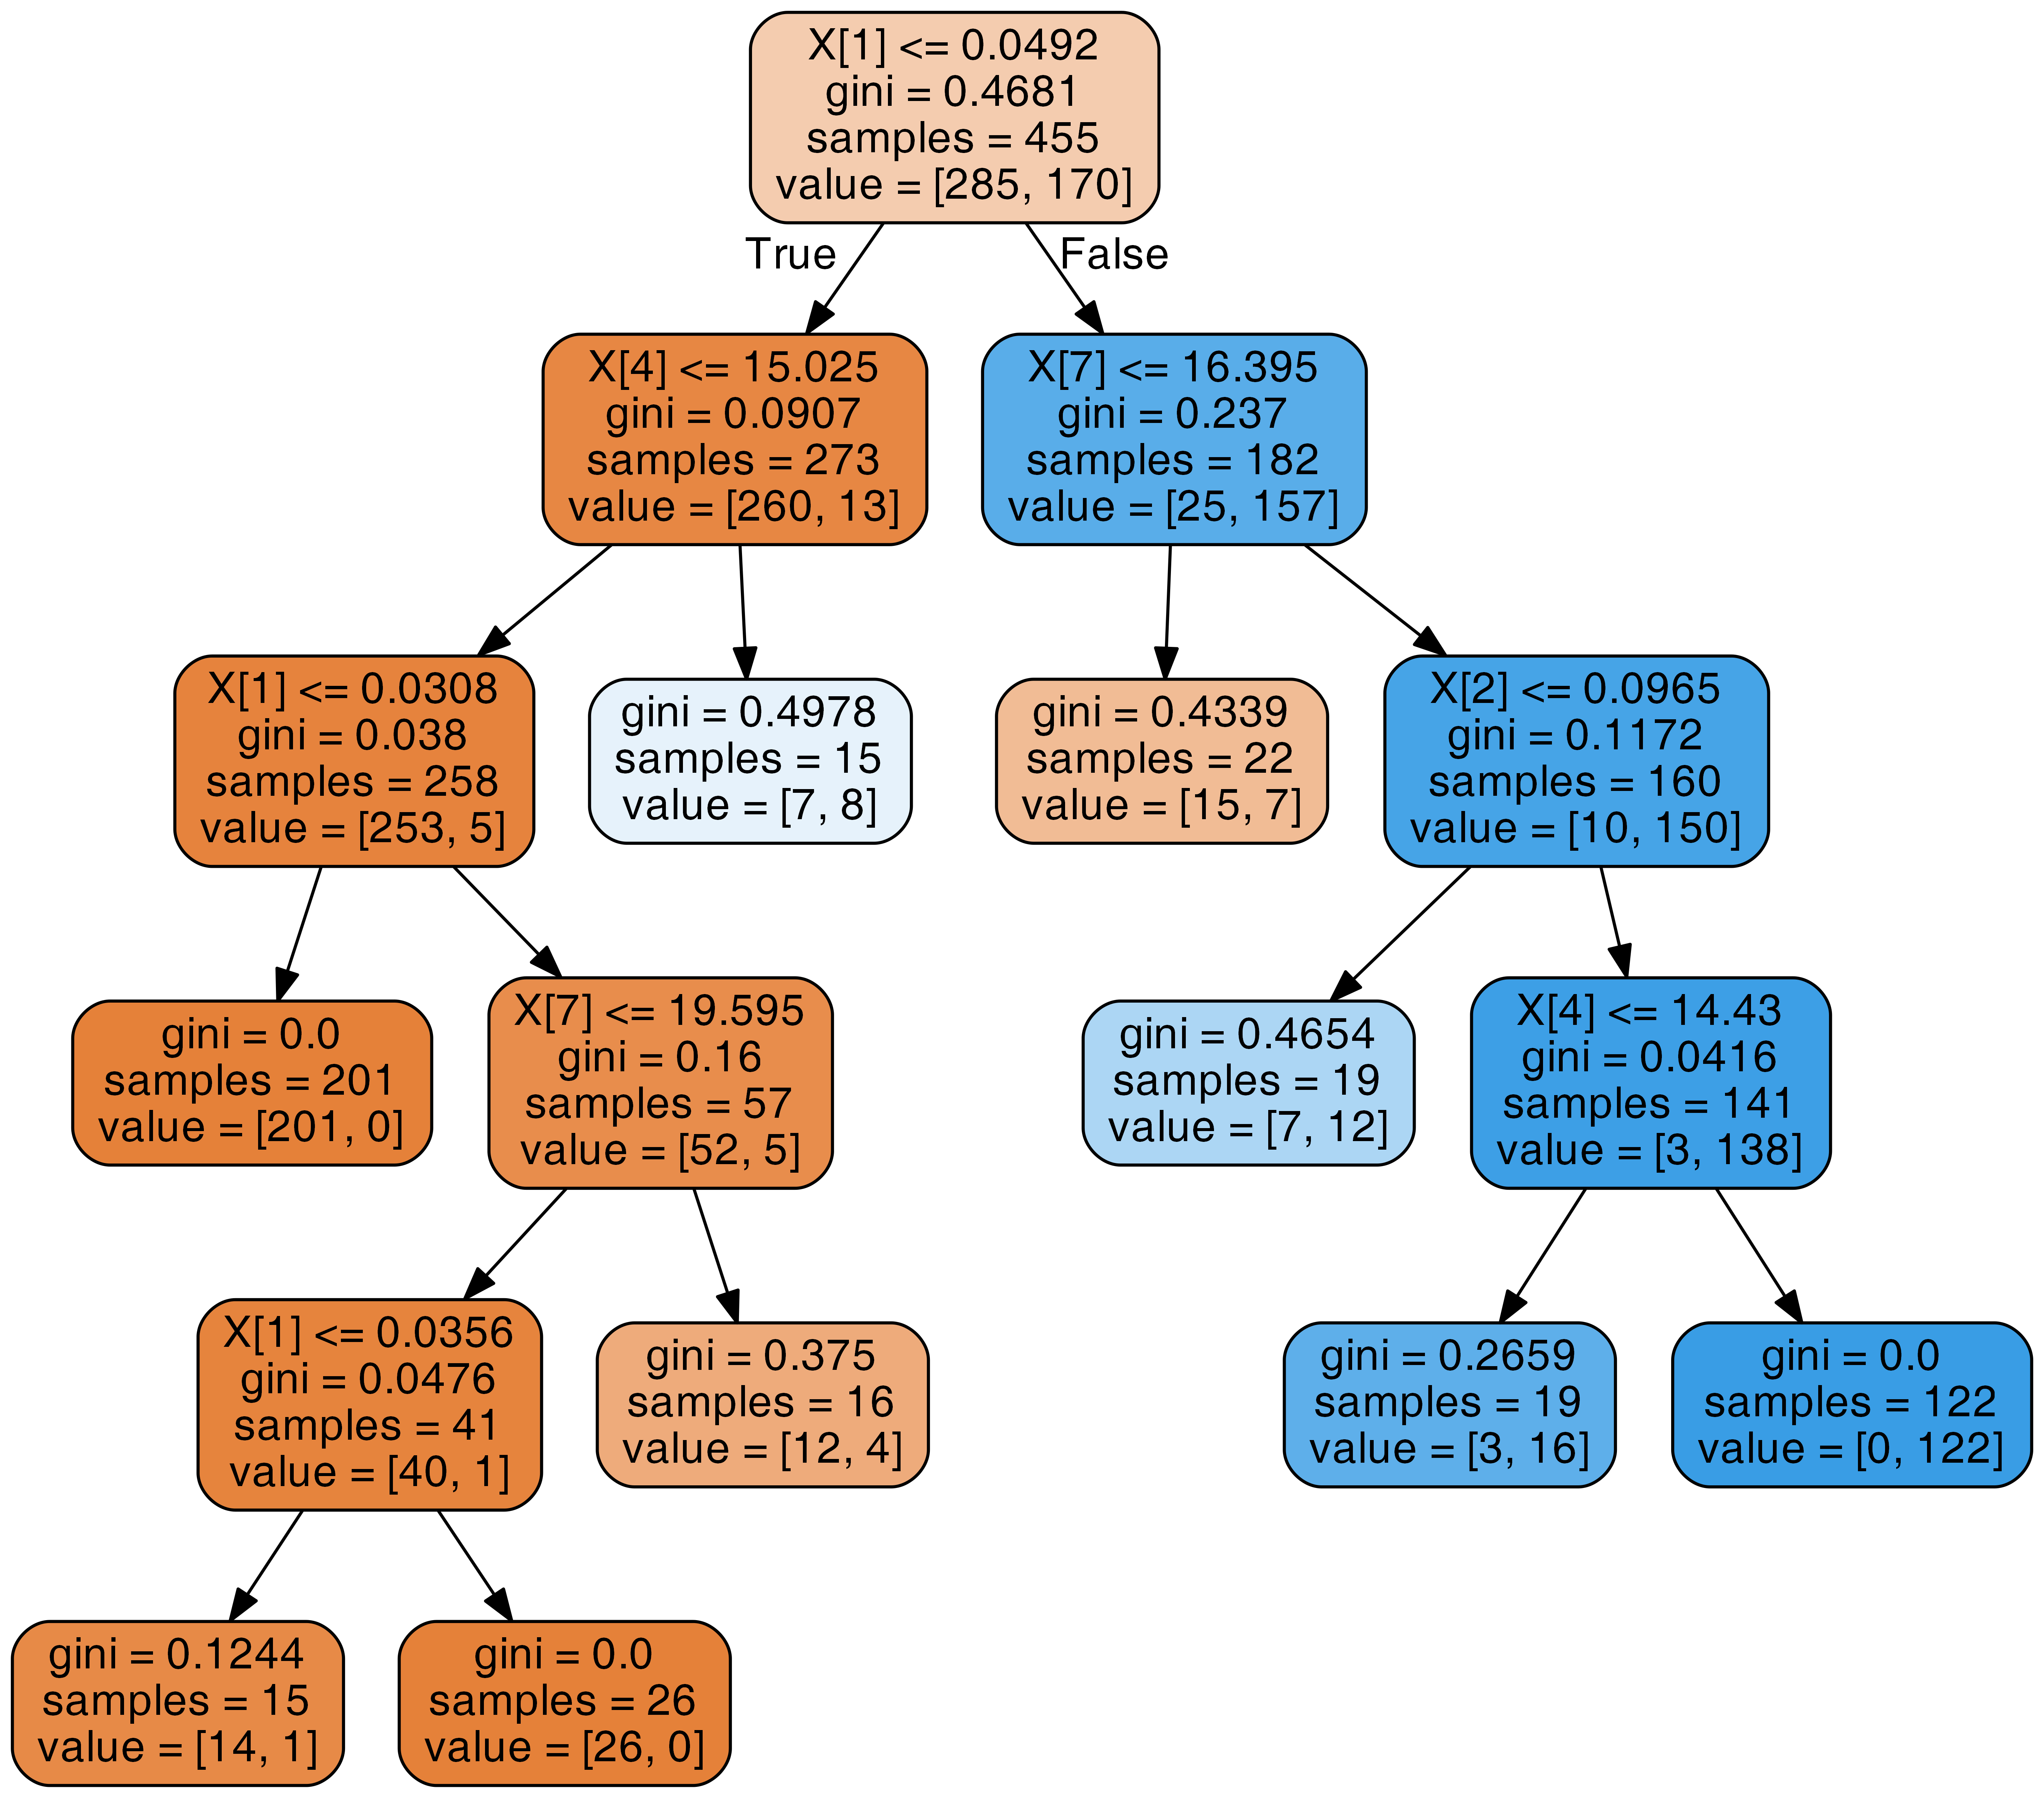

In [74]:
export_graphviz(dfit, out_file='tree.dot', rounded=True, proportion=False, filled=True)
!dot -Tpng tree.dot -o tree.png -Gdpi=600
Image(filename = 'tree.png')

### Cross Validation of Decision Tree

In [76]:
treeParameters = {'max_depth':[8, 10, 12], 'min_samples_leaf': [10, 15, 20]}
clf3 = GridSearchCV(dtree, param_grid=treeParameters, cv=3)
clf3.fit(X_train2, y_train2)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 10, 12], 'min_samples_leaf': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [77]:
clf3.best_score_

0.90989010989010988

In [78]:
print('Score for cross validation of decision tree is {0:.02f}'.format(clf3.score(X_test2, y_test2)))
print('Accuracy for decision tree model is {0:.2f}'.format(accuracy_score(y_test2, dtree.predict(X_test2))))
print('Confusion matrix for decision tree model is \n {0}'.format(confusion_matrix(y_test2, dtree.predict(X_test2))))

Score for cross validation of decision tree is 0.94
Accuracy for decision tree model is 0.89
Confusion matrix for decision tree model is 
 [[68  4]
 [ 8 34]]


## Conclusion:

#### In this example, the model that performed best was found when doing Cross Validation of Logistic Regression Model with fewer Mean variables (standardized).
#### Also, it is not a surprise that using cross validation to compare different model parameters improved performance metrics in all scenarios.